In [1]:
cd ..

/Users/joeranbosma/stack/Projects/M5Forecast


In [2]:
# basic imports
import os
import numpy as np
import pandas as pd
from tqdm import tqdm as tqdm
import matplotlib.pyplot as plt

# own imports
from flow import load_data, select_dates, sales_to_money, select_final_day, create_submission
from evaluation import Referee, CrossValiDataGenerator

os.environ['DATA_DIR'] = 'data/'
os.environ['SUB_DIR'] = 'submissions/'

# General settings for figures
plt.rcParams["figure.figsize"] = (9, 4.5)
plt.rcParams["savefig.format"] = "pdf"
plt.rcParams["savefig.dpi"] = 400
plt.rcParams["savefig.transparent"] = True
plt.rcParams.update({'font.size': 13})  # 12, 16
plt.rcParams["savefig.bbox"] = 'tight'

# Baseline for M5Forecast - Accuracy
This notebook calculates the mean of the final $k$ training days and multiplies those with the typical weekly pattern to create a slightly more advanced baseline. 

In [3]:
# Load data
calendar, sales_train_validation, sell_prices = load_data()

# select true sales period
sales_true = select_dates(sales_train_validation, day_end=1913, num_days=28, include_metadata=True)
sales_train = select_dates(sales_train_validation, day_start=1, num_days=1913-28, include_metadata=True)

# create referee with true sales
ref = Referee(sales_true, sales_train, sell_prices, calendar)

Calculating weights for each level...
Calculating scale for each level...
Finished setup.


## Determine weekly pattern

In [4]:
sales_train

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1881,d_1882,d_1883,d_1884,d_1885,item_id,dept_id,cat_id,store_id,state_id
id,,,,,,,,,,,,,,,,,,,,,
HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,0,...,2,0,1,1,1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA
HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,0,...,0,1,1,1,1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA
HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA
HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,0,...,3,5,0,6,6,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA
HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FOODS_3_823_WI_3_validation,0,0,2,2,0,3,1,4,1,0,...,0,0,0,0,0,FOODS_3_823,FOODS_3,FOODS,WI_3,WI
FOODS_3_824_WI_3_validation,0,0,0,0,0,5,0,1,1,3,...,0,0,0,0,0,FOODS_3_824,FOODS_3,FOODS,WI_3,WI
FOODS_3_825_WI_3_validation,0,6,0,2,2,4,1,8,5,2,...,0,0,2,0,1,FOODS_3_825,FOODS_3,FOODS,WI_3,WI


In [5]:
col_list = []
col_names = []

for i in range(1, 1+7):
    # select days from a certain day of the week
    cols = list(calendar[calendar.wday == i].d.values)
    col_name = calendar[calendar.wday == i].weekday.values[0]
    # filter days to match training set
    cols = [d for d in cols if d in sales_train.columns]
    col_list.append(cols); col_names.append(col_name)
    print("{} is day nr. {} of the week".format(col_name, i))

Saturday is day nr. 1 of the week
Sunday is day nr. 2 of the week
Monday is day nr. 3 of the week
Tuesday is day nr. 4 of the week
Wednesday is day nr. 5 of the week
Thursday is day nr. 6 of the week
Friday is day nr. 7 of the week


In [6]:
num_sales = [sales_train[cols].sum(axis=1).sum() for cols in col_list]

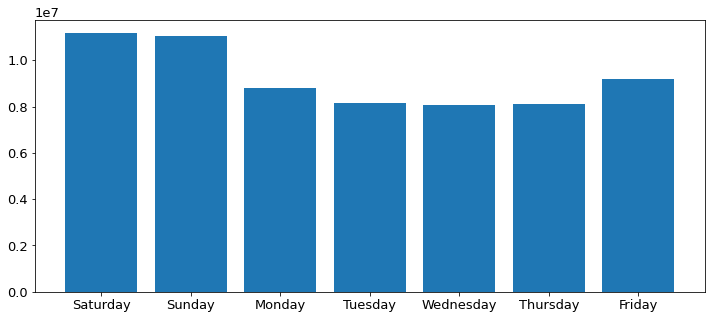

In [7]:
x = range(len(col_names))
f, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.bar(x, height=num_sales)
ax.set_xticks(x)
ax.set_xticklabels(col_names)
plt.show()

In [8]:
portions = np.array(num_sales) / np.sum(num_sales)
portions

array([0.17326312, 0.17140915, 0.13659388, 0.12618622, 0.12479437,
       0.12556788, 0.14218537])

## Predict weekly sales as mean of final $k$ days times weekly pattern
Based on the results shown in `k-day-average.ipynb`, $k$ is set to 30. 

In [9]:
portions

array([0.17326312, 0.17140915, 0.13659388, 0.12618622, 0.12479437,
       0.12556788, 0.14218537])

In [10]:
k = 30

# create skeleton for predictions
sales_pred = sales_true.copy()
day_cols = sales_pred.filter(regex='d_').columns
sales_pred[day_cols] = sales_pred[day_cols] * 0  # set all predictions to zero

# set all predictions to training mean of last k days
df = select_dates(sales_train, num_days=k, day_end=select_final_day(sales_train))
weekly_mean = df.filter(regex='d_').mean(axis=1) * 7
for dday in day_cols:
    week_day = calendar[calendar.d == dday].wday.values[0]
    portion = portions[week_day-1]
    sales_pred[dday] = weekly_mean * portion

# evaluate predictions
metrics = ref.evaluate(sales_pred)
print(metrics)

{1: 0.44473670919811226, 2: 0.5309613702515052, 3: 0.6342742743443948, 4: 0.5115191035988216, 5: 0.6105438957469964, 6: 0.6059013391185935, 7: 0.6835489802692778, 8: 0.7001896878515244, 9: 0.75668125825058, 10: 0.8677701966045377, 11: 0.8669267085805492, 12: 0.8529450762364333, 'WRMSSE': 0.672166550004277}


**Result**: Incorporating the weekly pattern reduces the WRMSSE signigicantly, from ~1.1 to ~0.67. 

## Create submission

In [11]:
create_submission(sales_pred, filename='weekly_pattern', add_timestamp=False)

Submit the predictions using:

`kaggle competitions submit -c m5-forecasting-accuracy -f submissions/submission_weekly_pattern.csv -m "Mean final 30 train days times weekly pattern"`

## Create forecast with days closest to validation set (which is used to compute local performance above)

In [12]:
k = 30

# create skeleton for predictions
sales_pred = sales_true.copy()
day_cols = sales_pred.filter(regex='d_').columns
sales_pred[day_cols] = sales_pred[day_cols] * 0  # set all predictions to zero

# set all predictions to training mean of last k days
df = select_dates(sales_train_validation, num_days=k, day_end=select_final_day(sales_train_validation))
weekly_mean = df.filter(regex='d_').mean(axis=1) * 7
for dday in day_cols:
    week_day = calendar[calendar.d == dday].wday.values[0]
    portion = portions[week_day-1]
    sales_pred[dday] = weekly_mean * portion

# evaluate predictions
metrics = ref.evaluate(sales_pred)
print("METRICS ON OVERLAPPING VALIDATION SET:", metrics)

METRICS ON OVERLAPPING VALIDATION SET: {1: 0.44978980014528047, 2: 0.5213134168553057, 3: 0.6045370372466206, 4: 0.5088181455325008, 5: 0.5868703224729095, 6: 0.5814197507465632, 7: 0.6463752112459633, 8: 0.658218364857601, 9: 0.7097552596300417, 10: 0.7617904650052487, 11: 0.778420783834012, 12: 0.7760724471580925, 'WRMSSE': 0.6319484170608449}


## Create submission

In [13]:
create_submission(sales_pred, filename='weekly_pattern_mean_d1884_d1913', add_timestamp=False)

Submit the predictions using:

`kaggle competitions submit -c m5-forecasting-accuracy -f submissions/submission_weekly_pattern_mean_d1884_d1913.csv -m "Mean final 30 days times weekly pattern"`

## Cross-validation of performance

In [14]:
cv_generator = CrossValiDataGenerator(sales_train_validation, train_size=28)
train, _ = cv_generator.get_train_val_split(fold=10, train_size=-1)

### Determine weekly pattern with training set

In [15]:
col_list = []
col_names = []

for i in range(1, 1+7):
    # select days from a certain day of the week
    cols = list(calendar[calendar.wday == i].d.values)
    col_name = calendar[calendar.wday == i].weekday.values[0]
    # filter days to match training set
    cols = [d for d in cols if d in train.columns]
    col_list.append(cols)

num_sales = [train[cols].sum(axis=1).sum() for cols in col_list]
portions = np.array(num_sales) / np.sum(num_sales)
portions

array([0.17337304, 0.17105435, 0.13658724, 0.12610984, 0.12460889,
       0.12514649, 0.14312014])

### Predict and evaluate

In [ ]:
k = 28
metrics_list = []

for fold in range(1, 1+10):
    train_df, val_df = cv_generator.get_train_val_split(fold=fold, train_size=k)

    # get skeleton for predictions
    sales_pred = val_df.copy()
    day_cols = sales_pred.filter(regex='d_').columns
    sales_pred[day_cols] = sales_pred[day_cols] * 0  # set all predictions to zero

    # set all predictions to training mean of last k days
    weekly_mean = train_df.filter(regex='d_').mean(axis=1) * 7
    for dday in day_cols:
        week_day = calendar[calendar.d == dday].wday.values[0]
        portion = portions[week_day-1]
        sales_pred[dday] = weekly_mean * portion

    # evaluate predictions
    ref = Referee(val_df, train_df, sell_prices, calendar)
    metrics = ref.evaluate(sales_pred)
    # print(metrics)
    metrics_list.append(metrics)

Calculating weights for each level...
Calculating scale for each level...
Finished setup.


In [ ]:
def plot_dict(dictionaries, exclude_zero=False, labels=[]):
    f, ax = plt.subplots(1, 1)
    
    if isinstance(dictionaries, dict):
        dictionaries = [dictionaries]
        labels = [labels]
    
    for i, dic in enumerate(dictionaries):
        keys = list(dic.keys())
        vals = list(dic.values())
        if exclude_zero:
            keys = [k for k in keys if k != 0]
            vals = [val for (k, val) in dic.items() if k != 0]
        
        try:
            ax.plot(keys, vals, label=labels[i])
        except:
            ax.plot(keys, vals)
    
    if len(labels) > 0:
        plt.legend(loc=(1.05, 0.))
    
    plt.show()

plot_dict(metrics_list, labels=['Fold %d'%d for d in range(1, 1+10)])